In [1]:
import pandas as pd
import numpy as np
from ape import chain, Contract, networks

In [2]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [3]:
mim_curve_pool = Contract("0x5a6A4D54456819380173272A5E8E9B9904BdF41B")
mim_curve_pool

<Vyper_contract 0x5a6A4D54456819380173272A5E8E9B9904BdF41B>

In [4]:
base_curve_pool = Contract("0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7")
base_curve_pool

<Vyper_contract 0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7>

In [5]:
# A = 2000
A = mim_curve_pool.A()
A

2000

In [6]:
# fee rate = (fee / FEE_PRECISION) * (1 + ADMIN_FEE / FEE_PRECISION)
FEE_PRECISION = 10**10

fee_rate = (mim_curve_pool.fee() / FEE_PRECISION) * (1 + mim_curve_pool.admin_fee() / FEE_PRECISION)
fee_rate

0.0006000000000000001

In [7]:
PRECISION = 10**18

In [8]:
# get the balances for mim and 3crv
# mim is coin0, 3crv is coin1
coin0_addr = mim_curve_pool.coins(0)
coin1_addr = mim_curve_pool.coins(1)

print(f"coin 0: {coin0_addr}")
print(f"coin 1: {coin1_addr}")

coin 0: 0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3
coin 1: 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490


In [9]:
mim = Contract(coin0_addr)
mim

<MagicInternetMoneyV1 0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3>

In [10]:
crv3 = Contract(coin1_addr)
crv3

<3Crv 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490>

In [11]:
bal_mim = mim_curve_pool.balances(0) / (10 ** mim.decimals()) # adjust for decimals
bal_3crv = mim_curve_pool.balances(1) / (10 ** crv3.decimals())

print(f"balance 0 (MIM): {bal_mim}")
print(f"balance 1 (3Crv): {bal_3crv}")

balance 0 (MIM): 53058592.676728524
balance 1 (3Crv): 47192342.03013704


In [12]:
# D calc for two coin case
def _d(x0, x1):
    # Cardano: t**3 + p*t + q = 0
    # SEE: https://en.wikipedia.org/wiki/Cubic_equation#Derivation_of_the_roots
    q = - 16 * A * x0 * x1 * (x0 + x1)
    p = 4 * x0 * x1 * (4 * A - 1)
    delta = ((q/2.0)**2 + (p/3.0)**3)**(1/2)
    
    u1 = (-q/2.0 + delta)**(1/3)
    u2 = (q/2.0 + delta)**(1/3)

    return u1 - u2

In [13]:
D = _d(bal_mim, bal_3crv)
D

100250891.66180706

In [14]:
# some stableswap fns for two coin case
def B(x):
    return D * (1 - 4*A) * x + 4*A*(x**2)

def E(x):
    return 4*A*x

def y(x):
    return (-B(x) + np.sqrt(B(x)**2 + (D**3) * E(x))) / (2 * E(x))

def p(x):
    return (y(x) / x) * ((D**3) + 16 * A * (x**2) * (y(x))) / ((D**3) + 16 * A * (x) * (y(x)**2))

def tvl(x):
    return x * p(x) + y(x)

In [15]:
# in line with current balance of 3crv in pool
print('y(bal_mim):', y(bal_mim))
print('y(bal_mim) / bal_3crv - 1:', y(bal_mim) / bal_3crv - 1)

y(bal_mim): 47192342.03013735
y(bal_mim) / bal_3crv - 1: 6.661338147750939e-15


In [16]:
# plot price for mim balances
xs = np.linspace(1000000, D, 100000)
prices = [ p(x) for x in xs ]
df = pd.DataFrame(data={'x': xs, 'price': prices})

<AxesSubplot: xlabel='x'>

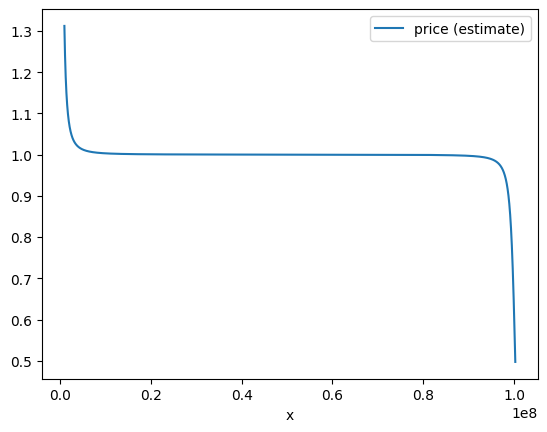

In [17]:
df.plot(x='x', y='price', label='price (estimate)')

<AxesSubplot: xlabel='x'>

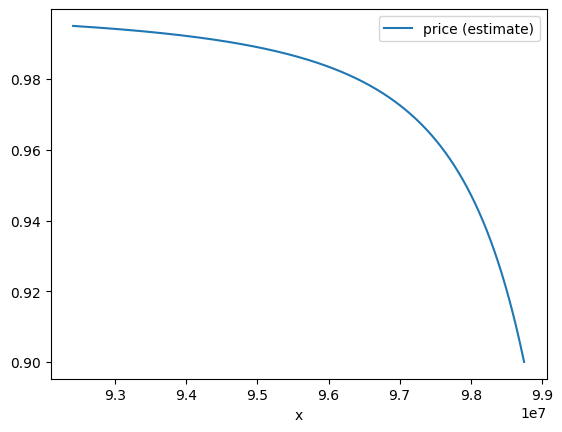

In [18]:
# zoom in near larger mim balance values for transition away from price of 1
df[(df['price'] < 0.995) & (df['price'] > 0.9)].plot(x='x', y='price', label='price (estimate)')

In [19]:
# get the inverse from linspace eval
df[abs(df['price'] - 0.9759) < 0.00005]

,x,price
96487,9.676517e+07,0.975950
96488,9.676616e+07,0.975937
96489,9.676715e+07,0.975924
96490,9.676814e+07,0.975911
96491,9.676914e+07,0.975899
96492,9.677013e+07,0.975886
96493,9.677112e+07,0.975873
96494,9.677211e+07,0.975860


In [20]:
# dx is estimated amount of MIM need to sell into pool to push price below strike
dx = df[abs(df['price'] - 0.9759) < 0.00005].iloc[-1].x - bal_mim
dx

43713520.4445468

In [21]:
# pool balances post sell below strike
print("p(bal_mim + dx):", p(bal_mim + dx))
print("x(bal_mim + dx):", bal_mim + dx)
print("y(bal_mim + dx):", y(bal_mim + dx))

p(bal_mim + dx): 0.9758600624755178
x(bal_mim + dx): 96772113.12127532
y(bal_mim + dx): 3557699.60982695


In [22]:
# percentage of pool in dollar terms needed to breach strike
print("tvl(bal_mim + dx):", tvl(bal_mim + dx))
print("x(bal_mim + dx) / tvl(bal_mim + dx):", (bal_mim + dx) * p(bal_mim + dx) / tvl(bal_mim + dx))
print("y(bal_mim + dx) / tvl(bal_mim + dx):", y(bal_mim + dx) / tvl(bal_mim + dx))

tvl(bal_mim + dx): 97993739.96624257
x(bal_mim + dx) / tvl(bal_mim + dx): 0.9636946236458316
y(bal_mim + dx) / tvl(bal_mim + dx): 0.0363053763541684


In [23]:
# how much does user get out in dollar terms after initial swap to breach?
dy = y(bal_mim) - y(bal_mim + dx)
dy

43634642.4203104

In [24]:
# NOTE: can use same Curve fns above if switch x <=> y due to symmetry, where p <=> 1/p
print("bal_mim:", bal_mim)
print("y(bal_3crv):", y(bal_3crv))
print("p(bal_mim):", p(bal_mim))
print("1/p(bal_3crv):", 1/p(bal_3crv))

bal_mim: 53058592.676728524
y(bal_3crv): 53058592.676728845
p(bal_mim): 0.9999705486537355
1/p(bal_3crv): 0.9999705486537355


In [25]:
# assume arbs eventually bring the balances back to (bal_mim, bal_3crv) before final swap by attacker
# amount of MIM out after final swap?
dx_out = y(bal_3crv) - y(bal_3crv + dy)
dx_out

43610526.04963141

In [26]:
# loss due to slippage in MIM (without fees)
slippage_loss = dx - dx_out
slippage_loss

102994.39491538703

In [27]:
# loss due to slippage in % terms (without fees; TODO: fees)
slippage_loss / dx

0.002356122176113488